<a href="https://colab.research.google.com/github/aainabatool/-IPKI-AI-DataScience-Course/blob/main/notebooks/FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets transformers evaluate accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.7 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np


**Load DataSet**


In [4]:
dataset = load_dataset("emotion")
dataset


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

**Tokenization**

In [5]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

encoded_dataset = dataset.map(tokenize, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
encoded_dataset = encoded_dataset.rename_column("label", "labels")   #Renames label → labels (Trainer expects labels).
encoded_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])  #Converts dataset to PyTorch tensors so Trainer can use them.

**Load Model**

“We add a classification head because DistilBERT by itself only produces embeddings. The head converts those embeddings into class probabilities (for our 6 emotions). Without it, the model can’t do classification.”

“The input sentence is first tokenized. DistilBERT processes tokens and outputs embeddings. The special [CLS] token represents the whole sentence. We pass that through a classification head (linear + softmax), which gives probabilities for each emotion class. That’s how the model predicts whether the text shows anger, joy, sadness, etc.”

In [7]:
num_labels = dataset["train"].features["label"].num_classes

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=num_labels
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model outputs logits → converted to probabilities → used for classification.

**Metrics**

logits = raw model outputs before softmax

argmax → picks the class with highest score.

Accuracy → measures overall correctness.

F1-macro → averages performance across all classes equally (important for unbalanced datasets).

In [8]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    f1_macro = f1.compute(predictions=predictions, references=labels, average="macro")
    return {"accuracy": acc["accuracy"], "f1_macro": f1_macro["f1"]}


“No, logits are not the predictions. They are the raw, unnormalized scores output by the model. We apply softmax to convert them into probabilities, and then take the argmax to get the actual predicted class.”

**Training Arguments**

In [9]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,        #prevents overfitting.
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
)

**Trainer**

In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


/tmp/ipython-input-4052799942.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


**Train**

7065d1e896eff136eefcd1180b500eb98346a857


In [11]:
trainer.train()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: b-aaina (b-aaina-comsats-university-islamabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.228200,0.194002,0.931000,0.902574
2,0.139200,0.167547,0.935500,0.908778
3,0.077300,0.170093,0.934500,0.908372


TrainOutput(global_step=3000, training_loss=0.24324331728617352, metrics={'train_runtime': 585.2702, 'train_samples_per_second': 82.013, 'train_steps_per_second': 5.126, 'total_flos': 1589722177536000.0, 'train_loss': 0.24324331728617352, 'epoch': 3.0})

**Evaluation**

In [12]:
results_finetuned = trainer.evaluate(encoded_dataset["test"])
print(results_finetuned)


{'eval_loss': 0.1741785705089569, 'eval_accuracy': 0.928, 'eval_f1_macro': 0.8833396769645022, 'eval_runtime': 6.7805, 'eval_samples_per_second': 294.963, 'eval_steps_per_second': 18.435, 'epoch': 3.0}


# **Compare with Base (Pretrained) Model**

In [13]:
from transformers import pipeline

# Zero-shot (no fine-tuning)
clf = pipeline("text-classification", model=checkpoint, tokenizer=tokenizer)
sample = dataset["test"][0]["text"]
print("Sample text:", sample)
print("Base Model Prediction:", clf(sample))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


Sample text: im feeling rather rotten so im not very ambitious right now
Base Model Prediction: [{'label': 'LABEL_0', 'score': 0.5296288728713989}]


In [14]:
clf_finetuned = pipeline("text-classification", model=model, tokenizer=tokenizer)
print("Fine-Tuned Prediction:", clf_finetuned(sample))


Device set to use cuda:0


Fine-Tuned Prediction: [{'label': 'LABEL_0', 'score': 0.9982628226280212}]


**Confusion Matrix**

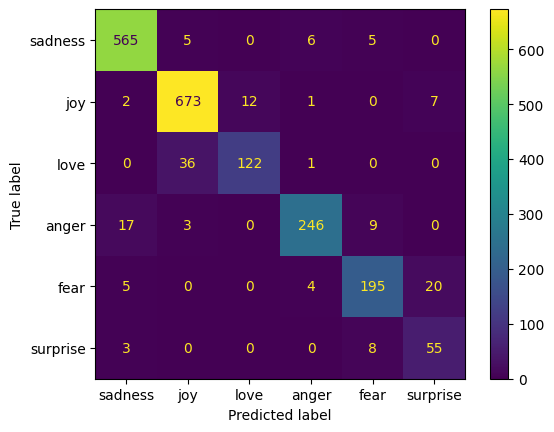

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

preds = trainer.predict(encoded_dataset["test"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=dataset["train"].features["label"].names)
plt.show()


ows = True labels (actual emotion in dataset).

Columns = Predicted labels (what model guessed).

Diagonal values = correct predictions (good).

Off-diagonal values = misclassifications (errors).

In [16]:
from transformers import pipeline

# Load your fine-tuned model + tokenizer
emotion_clf = pipeline(
    "text-classification",
    model="./results/checkpoint-best",   # path where Trainer saved your best model
    tokenizer="distilbert-base-uncased",
    return_all_scores=True   # so we can see probabilities for all classes
)

# --- Test cases ---
texts = [
    "I am so happy to see you again!",        # joy
    "I feel really lonely and sad today.",    # sadness
    "I love spending time with my family.",   # love
    "This situation makes me so angry!",      # anger
    "I was scared walking home at night.",    # fear
    "Wow, I didn’t expect that surprise!",    # surprise
]

# Run predictions
for t in texts:
    result = emotion_clf(t)
    print(f"\nInput: {t}")
    for r in result[0]:
        print(f"{r['label']}: {r['score']:.3f}")

HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': './results/checkpoint-best'. Use `repo_type` argument if needed.